# FlashCam Image Clustering

K-means clustering of FlashCam telescope images to separate:
- Complete muon rings
- Partial rings (arcs)
- Ring + shower combinations
- Shower-only events

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tables
import os
from tqdm import tqdm

from tensorflow import keras
from keras import layers  # Add this line
from keras.applications import VGG19
from keras.applications.vgg19 import preprocess_input

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score, davies_bouldin_score

from skimage.transform import resize

np.random.seed(42)
print("Libraries loaded")

2025-12-11 17:14:26.880185: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Libraries loaded


## Parameters

In [18]:
# Data
data_dir = '../data/flashcam'
num_images = 10000
test_fraction = 0.2

# Intensity filter (remove events below these percentiles, None = no filter)
pixel_percentile_cut = 20
intensity_percentile_cut = 20

# PCA dimensionality reduction
pca_dims = 512

# Clustering
k_values = [2]
examples_per_cluster = 8

# Autoencoder
latent_dim = 128
autoencoder_epochs = 50
autoencoder_batch_size = 128

## Load Data

In [3]:
def load_data(data_dir, num_images, file_range=None):
    """Load FlashCam images from HDF5 files.
    
    Parameters:
    -----------
    file_range : int, tuple (start, end), 'all', or None
        - None: load files until num_images is reached
        - int: load only that file index (e.g., 0 for first file)
        - (start, end): load files from index start to end-1
        - 'all': load all available files
    """
    
    h5_files = sorted([f for f in os.listdir(data_dir) if f.endswith('.h5')])
    if not h5_files:
        raise ValueError(f"No HDF5 files in {data_dir}")
    
    print(f"Found {len(h5_files)} files")
    
    # Determine which files to load
    if file_range is None:
        files_to_load = h5_files  # Will stop when num_images is reached
        print(f"Loading until {num_images} images are reached...")
    elif file_range == 'all':
        files_to_load = h5_files
        print(f"Loading from ALL {len(files_to_load)} files")
    elif isinstance(file_range, int):
        files_to_load = [h5_files[file_range]]
        print(f"Loading from file {file_range}: {h5_files[file_range]}")
    else:
        start_idx, end_idx = file_range
        files_to_load = h5_files[start_idx:end_idx]
        print(f"Loading from {len(files_to_load)} files (indices {start_idx} to {end_idx-1})")
    
    all_images = []
    all_event_ids = []
    total = 0
    
    for filename in files_to_load:
        if num_images is not None and total >= num_images:
            break
            
        filepath = os.path.join(data_dir, filename)
        with tables.open_file(filepath, 'r') as f:
            if num_images is None:
                n = len(f.root.images)
            else:
                remaining = num_images - total
                n = min(remaining, len(f.root.images))
            
            all_images.append(f.root.images[:n])
            all_event_ids.append(f.root.event_nr[:n])
            total += n
    
    images = np.concatenate(all_images)
    event_ids = np.concatenate(all_event_ids)
    
    print(f"Loaded {len(images)} images from {len(all_images)} file(s), shape {images[0].shape}")
    
    return images, event_ids

all_imgs, all_ids = load_data(data_dir, num_images, file_range=0)

Found 162 files
Loading from file 0: flashcam_run178799_full_000.h5
Loaded 10000 images from 1 file(s), shape (56, 56)


## Preprocess

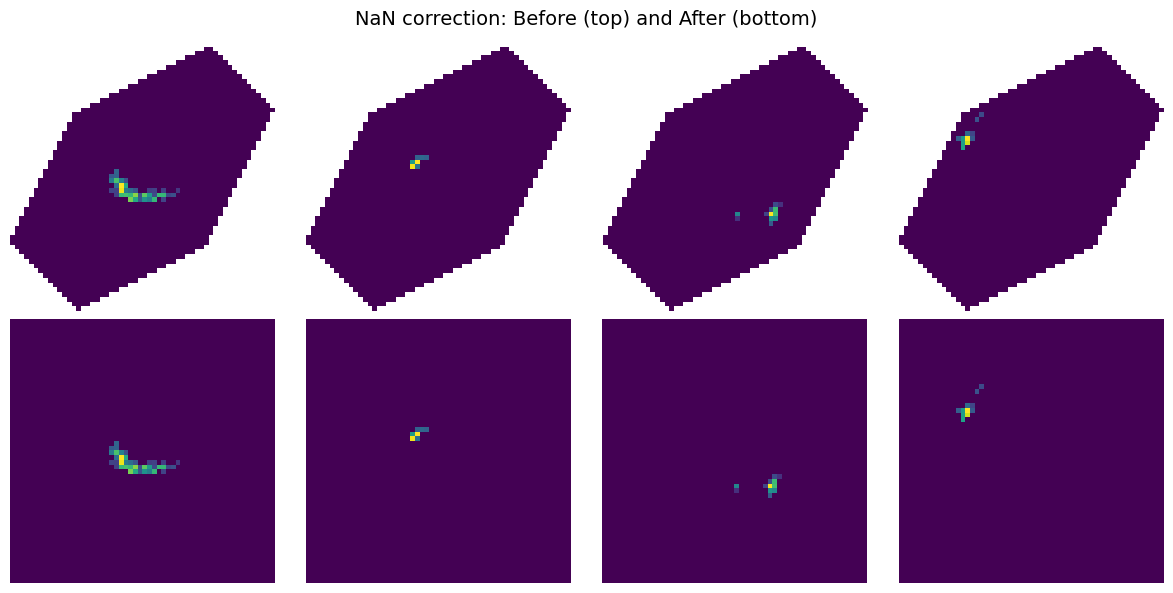

In [4]:
# Select random images to show before/after
indices = np.random.choice(len(all_imgs), 4, replace=False)

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
fig.suptitle("NaN correction: Before (top) and After (bottom)", fontsize=14)

# Before correction
for i, idx in enumerate(indices):
    axes[0, i].imshow(all_imgs[idx], cmap='viridis')
    axes[0, i].axis('off')

# Replace NaN pixels with 0
all_imgs = np.nan_to_num(all_imgs, nan=0.0)

# After correction (same images)
for i, idx in enumerate(indices):
    axes[1, i].imshow(all_imgs[idx], cmap='viridis')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

## Filtering

In [5]:
# Filter intensity BEFORE train/test split
def filter_intensity(images, event_ids, pixel_percentile=None, intensity_percentile=None):
    """Remove low-intensity events below the given percentiles. If None, no filter applied."""
    
    if pixel_percentile is None and intensity_percentile is None:
        print("No intensity filtering applied")
        return images, event_ids
    
    active_pixels = (images > 0).sum(axis=(1, 2))
    total_intensity = images.sum(axis=(1, 2))
    
    keep = np.ones(len(images), dtype=bool)
    
    # Apply pixel filter if specified
    if pixel_percentile is not None:
        min_pixels_threshold = np.percentile(active_pixels, pixel_percentile)
        keep &= (active_pixels >= min_pixels_threshold)
        print(f"Pixel percentile cut: {pixel_percentile}%")
        print(f"Min pixels threshold: {min_pixels_threshold:.1f}")
    
    # Apply intensity filter if specified
    if intensity_percentile is not None:
        min_intensity_threshold = np.percentile(total_intensity, intensity_percentile)
        keep &= (total_intensity >= min_intensity_threshold)
        print(f"Intensity percentile cut: {intensity_percentile}%")
        print(f"Min intensity threshold: {min_intensity_threshold:.1f}")
    
    print(f"Before: {len(images)} events")
    print(f"After: {keep.sum()} events ({keep.sum()/len(images)*100:.1f}%)")
    print(f"Removed: {(~keep).sum()} events")
    
    return images[keep], event_ids[keep]

# Apply filter before splitting
all_imgs, all_ids = filter_intensity(all_imgs, all_ids, pixel_percentile_cut, intensity_percentile_cut)

Pixel percentile cut: 20%
Min pixels threshold: 7.0
Intensity percentile cut: 20%
Min intensity threshold: 90.9
Before: 10000 events
After: 7674 events (76.7%)
Removed: 2326 events


## Normalization

Before normalization - Data range: [0.0, 290.9]


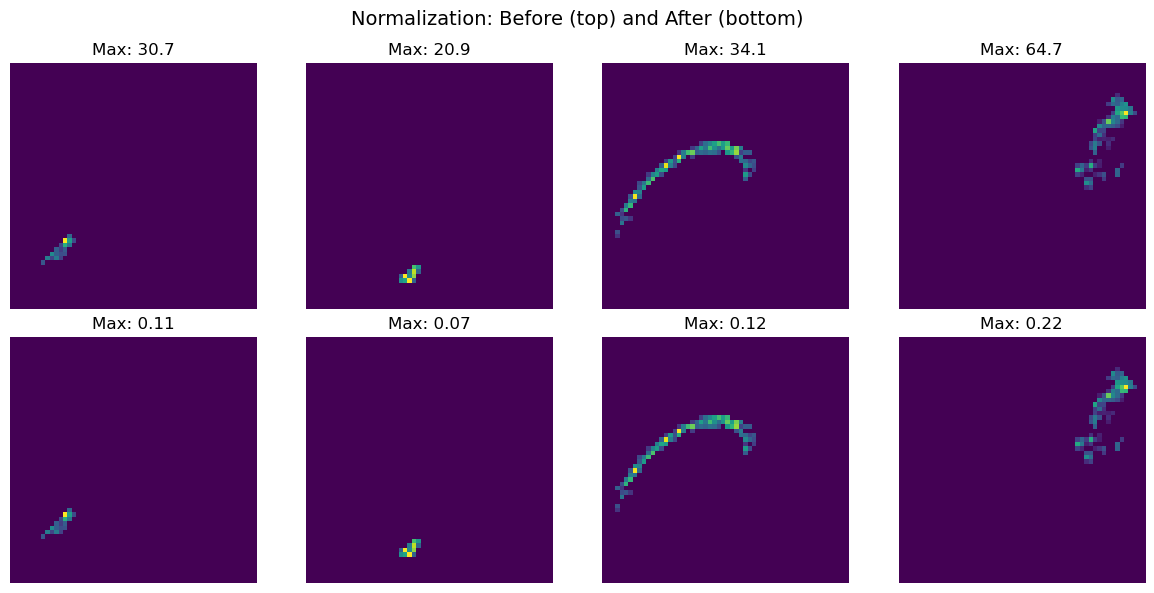

In [6]:
# Normalize all data
print(f"Before normalization - Data range: [{all_imgs.min():.1f}, {all_imgs.max():.1f}]")

# Show examples before normalization
indices = np.random.choice(len(all_imgs), 4, replace=False)

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
fig.suptitle("Normalization: Before (top) and After (bottom)", fontsize=14)

# Before normalization
for i, idx in enumerate(indices):
    axes[0, i].imshow(all_imgs[idx], cmap='viridis')
    axes[0, i].axis('off')
    axes[0, i].set_title(f'Max: {all_imgs[idx].max():.1f}')

# Normalize to [0, 1]
all_imgs = all_imgs / all_imgs.max()

# After normalization
for i, idx in enumerate(indices):
    axes[1, i].imshow(all_imgs[idx], cmap='viridis')
    axes[1, i].axis('off')
    axes[1, i].set_title(f'Max: {all_imgs[idx].max():.2f}')

plt.tight_layout()
plt.show()

## Splitting

In [7]:
# Now split into train/test
train_imgs, test_imgs, train_ids, test_ids = train_test_split(
    all_imgs, all_ids, test_size=test_fraction, random_state=42
)

print(f"\nTrain: {len(train_imgs)}, Test: {len(test_imgs)}")


Train: 6139, Test: 1535


## Autoencoder

In [8]:
# Add channel dimension for autoencoder
train_ae = train_imgs[..., np.newaxis]
test_ae = test_imgs[..., np.newaxis]
print(f"Training shape: {train_ae.shape}, Test shape: {test_ae.shape}")

Training shape: (6139, 56, 56, 1), Test shape: (1535, 56, 56, 1)


In [9]:
def build_autoencoder(input_shape, latent_dim):
    """Build convolutional autoencoder for FlashCam images."""
    
    # Encoder
    encoder_input = keras.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoder_input)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Flatten()(x)
    encoded = layers.Dense(latent_dim, activation='relu', name='encoded')(x)
    
    # Decoder
    x = layers.Dense(7 * 7 * 128, activation='relu')(encoded)
    x = layers.Reshape((7, 7, 128))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    
    # Models
    autoencoder = keras.Model(encoder_input, decoded, name='autoencoder')
    encoder = keras.Model(encoder_input, encoded, name='encoder')
    
    return autoencoder, encoder

# Build model
input_shape = (56, 56, 1)
latent_dim = 128
autoencoder, encoder = build_autoencoder(input_shape, latent_dim)

print("Autoencoder architecture:")
autoencoder.summary()

Autoencoder architecture:


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 56, 56, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 56, 56, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoded (Dense)                 │ (None, 128)            │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6272)           │       809,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 7, 7, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,944,833 (7.42 MB)

 Trainable params: 1,944,833 (7.42 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Extract encoder embeddings (Sam's recommendation)
print("Extracting encoder embeddings from bottleneck...")
features_train = encoder.predict(train_ae, batch_size=128, verbose=1)
features_test = encoder.predict(test_ae, batch_size=128, verbose=1)

print(f"\nFeatures extracted:")
print(f"  Train: {features_train.shape}")
print(f"  Test: {features_test.shape}")

Extracting encoder embeddings from bottleneck...
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

Features extracted:
  Train: (6139, 128)
  Test: (1535, 128)


In [ ]:
# Compile and train
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

history = autoencoder.fit(
    train_ae, train_ae,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_data=(test_ae, test_ae),
    verbose=1
)

# Plot training history
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Autoencoder Training')
plt.show()

print(f"Final training loss: {history.history['loss'][-1]:.4f}")
print(f"Final validation loss: {history.history['val_loss'][-1]:.4f}")

Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 13s 227ms/step - loss: 0.2601 - val_loss: 0.0042
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 11s 221ms/step - loss: 0.0036 - val_loss: 0.0025
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 11s 221ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 11s 220ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 11s 221ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 6/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 11s 222ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 7/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 11s 222ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 8/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 11s 220ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 9/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 11s 223ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 10/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 219ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 11/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 11s 222ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 12/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 11

In [ ]:
# Show original vs reconstructed images
test_reconstructed = autoencoder.predict(test_ae[:8])

fig, axes = plt.subplots(2, 8, figsize=(16, 4))
fig.suptitle('Original (top) vs Reconstructed (bottom)', fontsize=14)

for i in range(8):
    axes[0, i].imshow(test_ae[i, :, :, 0], cmap='viridis')
    axes[0, i].axis('off')
    axes[1, i].imshow(test_reconstructed[i, :, :, 0], cmap='viridis')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Extract encoder embeddings
features_train = encoder.predict(train_ae, batch_size=128, verbose=1)
features_test = encoder.predict(test_ae, batch_size=128, verbose=1)

In [ ]:
# PCA
pca_dims = 50  # o il valore che hai nei parametri
pca = PCA(n_components=pca_dims, random_state=42)
train_pca = pca.fit_transform(features_train)
test_pca = pca.transform(features_test)

variance_explained = pca.explained_variance_ratio_.sum()
print(f"PCA: {features_train.shape[1]} to {pca_dims} dimensions")
print(f"Variance explained: {variance_explained:.1%}")

## K-means Clustering

In [ ]:
kmeans_results = {}

for k in k_values:
    print(f"\nK-means with k={k}")
    
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
    train_labels = kmeans.fit_predict(train_pca)
    test_labels = kmeans.predict(test_pca)
    
    # Quality metrics
    silhouette = silhouette_score(train_pca, train_labels)
    davies_bouldin = davies_bouldin_score(train_pca, train_labels)
    
    kmeans_results[k] = {
        'model': kmeans,
        'train_labels': train_labels,
        'test_labels': test_labels,
        'silhouette': silhouette,
        'davies_bouldin': davies_bouldin
    }
    
    print(f"  Silhouette: {silhouette:.3f} (higher is better)")
    print(f"  Davies-Bouldin: {davies_bouldin:.3f} (lower is better)")
    
    # Cluster sizes
    unique, counts = np.unique(train_labels, return_counts=True)
    for cluster, count in zip(unique, counts):
        print(f"  Cluster {cluster}: {count} images ({count/len(train_labels)*100:.1f}%)")

## Visualize Clusters

In [ ]:
def visualize_clusters(labels, images, k, n_examples):
    """Show example images from each cluster."""
    
    fig, axes = plt.subplots(k, n_examples, figsize=(n_examples*2, k*2))
    if k == 1:
        axes = axes.reshape(1, -1)
    
    for cluster in range(k):
        cluster_imgs = images[labels == cluster]
        n_show = min(n_examples, len(cluster_imgs))
        
        # Random sample from cluster
        indices = np.random.choice(len(cluster_imgs), n_show, replace=False)
        
        for i in range(n_examples):
            ax = axes[cluster, i]
            if i < n_show:
                ax.imshow(cluster_imgs[indices[i]], cmap='viridis')
                if i == 0:
                    ax.set_ylabel(f'Cluster {cluster}\n({len(cluster_imgs)} imgs)', 
                                  fontsize=10)
            ax.axis('off')
    
    plt.suptitle(f'K-means with k={k}', fontsize=14)
    plt.tight_layout()
    plt.show()

# Visualize each k
for k in k_values:
    result = kmeans_results[k]
    visualize_clusters(result['train_labels'], train_imgs, k, examples_per_cluster)

## Save Results

In [ ]:
output_dir = '../results'
os.makedirs(output_dir, exist_ok=True)

# Save PCA features
np.save(os.path.join(output_dir, 'features_train_pca.npy'), train_pca)
np.save(os.path.join(output_dir, 'features_test_pca.npy'), test_pca)

# Save clustering results for each k
for k, result in kmeans_results.items():
    np.savez(
        os.path.join(output_dir, f'kmeans_k{k}.npz'),
        train_labels=result['train_labels'],
        test_labels=result['test_labels'],
        train_ids=train_ids,
        test_ids=test_ids,
        silhouette=result['silhouette'],
        davies_bouldin=result['davies_bouldin']
    )